Here goes the code to generate the epithelial integrated object and the DR space computation.
It will also contain the plots and code originally planned to go with the clusterDE, DA and entropy notebooks.

In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.11.1-CAPI-1.17.1
and GEOS at installation 3.10.3-CAPI-1.16.1differ”
Attaching SeuratObject

Attaching sp



# Data ingestion and preparation

We will use 21 datasets containing epithelial organoid cells from the experiment.

These individual datasets have been previously loaded into Seurat objects and QC and scaling/normalisation have been applied as shown in the **Exploration** notebook.

To run this section you will need to access the datasets hosted in *DATA REPO* and uncomment the code chunks below.


#Define input directories

    #These will have to point to the individual seurat objects
    data_dir <- "../ZenodoRepo/"

    #Load data from Run 1
    dlist_OrgMonocultures <- readRDS(paste0(data_dir,"monocultures.rds"))
    dlist_OrgCocultWT <- readRDS(paste0(data_dir,"crctmeWT.rds"))
    dlist_OrgCocultA <- readRDS(paste0(data_dir,"crctmeA.rds"))
    dlist_OrgCocultAK <- readRDS(paste0(data_dir,"crctmeAK.rds"))
    dlist_OrgCocultAKP <- readRDS(paste0(data_dir,"crctmeAKP.rds"))

    #Load data from the second run
    dlist_Run2 <- readRDS(paste0(data_dir, "aug21_WTorg.rds"))
    
    #Prepare both object lists
    dlist_Run1 <- c(
        dlist_OrgMonocultures, dlist_OrgCocultWT, dlist_OrgCocultA,
        dlist_OrgCocultAK, dlist_OrgCocultAKP)
    rm(dlist_OrgMonocultures, dlist_OrgCocultWT, dlist_OrgCocultA,
        dlist_OrgCocultAK, dlist_OrgCocultAKP)
    for (i in 1:length(dlist_Run1)) {
        print(dlist_Run1[[i]]@project.name)
        names(dlist_Run1)[i] <- dlist_Run1[[i]]@project.name
        dlist_Run1[[i]]@meta.data$clusters <- dlist_Run1[[i]]@active.ident
        dlist_Run1[[i]]@active.assay <- "RNA"
    }
    for (i in 1:length(dlist_Run2)) {
        print(dlist_Run2[[i]]@project.name)
        names(dlist_Run2)[i] <- dlist_Run2[[i]]@project.name
        dlist_Run2[[i]]@meta.data$clusters <- dlist_Run2[[i]]@active.ident
        dlist_Run2[[i]]@active.assay <- "RNA"
    }

#View objects from the 1st run

    for (i in 1:length(dlist_Run1)) {
        p1 <- DimPlot(dlist_Run1[[i]], reduction = "pca", group.by = "clusters") +
            egg::theme_article()
        p2 <- FeaturePlot(dlist_Run1[[i]], reduction = "pca",
            features = c("Epcam", "Pdgfra","Ptprc"), combine = FALSE)
        print(p1+p2+
            plot_layout(ncol=2, nrow = 2)+
            plot_annotation(title=names(dlist_Run1)[i],
                tag_levels = "A")
        )
    }

#View objects from the 2nd run

    for (i in 1:length(dlist_Run2)) {
        p1 <- DimPlot(dlist_Run2[[i]], reduction = "pca", group.by = "clusters") +
            egg::theme_article()
        p2 <- FeaturePlot(dlist_Run2[[i]], reduction = "pca",
            features = c("Epcam", "Pdgfra","Ptprc"), combine = FALSE)
        print(p1+p2+
            plot_layout(ncol=2, nrow = 2)+
            plot_annotation(title=names(dlist_Run2)[i],
                tag_levels = "A")
        )
    }

#Select epithelial clusters and merge both lists

    #1st Run
    for (i in 1:length(dlist_Run1)) {
    dlist_Run1[[i]] <- subset(dlist_Run1[[i]], idents = levels(
        dlist_Run1[[i]]@meta.data$clusters)[startsWith(levels(dlist_Run1[[i]]@meta.data$clusters),
        "e")]
        )
    }
    dlist_INTepi <- dlist_Run1
    #2nd Run
    dlist_INTepi <- append(dlist_INTepi,
        c(
            subset(dlist_Run2[[1]], subset = clusters %in% c(1)),
            subset(dlist_Run2[[2]], subset = clusters %in% c(1)),
            subset(dlist_Run2[[3]], subset = clusters %in% c(2)),
            dlist_Run2[[4]],
            dlist_Run2[[5]]
        ))
    for (i in 1:length(dlist_INTepi)) {
        names(dlist_INTepi)[i] <- dlist_INTepi[[i]]@project.name
    }
    dlist_INTepi

# Integration

The datasets are integrated using Seurat's workflow for RPCA integration of datasets normalised via SCTransform with the following key parameters:

* SelectIntegrationFeatures(
    nfeatures = 4000
    )
* FindIntegrationAnchors(
    normalization.method = "SCT",
    reduction = "rpca", 
    k.anchor = 12
    )

As this computation requires over 50GB of memory, we have hosted the resulting integrated object in *DATA REPO*.
Alternatively, a downsampled version of the integrated object (with just the *RNA* assay) is stored locally in this repository and can be used to explore gene expression and metadata values on the integrated DR space.

Filtering parameters where chosen as shown in the Preprocessing notebook, with a somewhat lenient (for epithelial cells) nFeature_RNA threshold at 1660.

Furthermore, cells with no expression for any of some bona fide highly expressed pan-epithelial markers were also removed from the object as follows:

    subset(SeuratObject,
        subset = Epcam>0 & Krt8>0 & Krt19>0 & Krt18>0 & Cldn7>0)

<!-- Cells with an scaled Dcn expression over 1.4 were labelled with a metadata column. 
These mostly fall within the TA2 cluster and might be doublets, but we were unable to unequivocally identify them.

    fibrolike_cells <- INTepi21_filt@meta.data %>%
                        rownames_to_column() %>%
                        mutate(fibrolike = case_when(
                                    rowname %in%  WhichCells(INTepi21_filt, expression = `Dcn`>=1.4) ~ "1",
                                    TRUE ~ "0",
                                    ),
                            .keep="used"
                            ) %>%
                        column_to_rownames(var="rowname")
    INTepi21_filt <- AddMetaData(INTepi21_filt, fibrolike_cells,
                                col.name = "fibrolike")

    DimPlot(INTepi21_filt,
            reduction = "phate", group.by = "curatedCLUST", split.by = "fibrolike",
            label = TRUE, label.box = FALSE, shuffle = TRUE, repel = TRUE) -->

In [8]:
#Load full object from data repo:

    d_Fig2_INTepi <- readRDS("../ZenodoRepo/d_Fig2_INTepi.rds")
    d_Fig2_INTepi
    #Make subsampled version
    d_Fig2_INTepi = SetIdent(d_Fig2_INTepi, value="curatedCLUST")
    dsub_Fig2_INTepi <- subset(d_Fig2_INTepi, downsample = 30)
    dsub_Fig2_INTepi@assays$SCT <- NULL
    dsub_Fig2_INTepi@assays$UCellRanks <- NULL
    saveRDS(dsub_Fig2_INTepi, "data/dsub_Fig2_INTepi.rds")

An object of class Seurat 
84714 features across 29452 samples within 4 assays 
Active assay: RNA (27434 features, 0 variable features)
 3 other assays present: SCT, integrated, UCellRanks
 7 dimensional reductions calculated: pca, umap, phate, pca_epi, umap_epi, phate_epi, phate_epi2

# Dimensionality Reduction and clusters

Replicate the necessary steps to reproduce Figure 2A.
The random seed to generate the PHATE embedding was not saved, so you can either
use the phate_epi DimRed layer already stored in the object or generate a new
similar one with the code below.

PC_ 1 
Positive:  Pclaf, Krt14, Rps2, Ube2c, Ccnd1, Birc5, Rrm2, Stmn1, S100a7a, H1f5 
	   Krt7, Ctla2a, S100a14, Hspd1, Phgdh, Npm1, Clu, Hmgb2, Top2a, Ptma 
	   Ccna2, Ranbp1, Cdca8, Prc1, Hsp90ab1, Gpx2, Ncl, Fabp5, Krt18, Tnnt2 
Negative:  Lypd8, AA467197, Prap1, Ifi27l2b, Abhd11os, Tm4sf20, Gsta1, Tmem45b, Calml4, Ckmt1 
	   Krt20, Cystm1, Muc13, Tspan8, Gsta4, Selenbp1, Cyp4f14, Phgr1, Tm6sf2, Rnf186 
	   Mgst3, Ppp1r14d, 2610528A11Rik, Lgals3, Sult1b1, Serpinb1a, Sult1d1, Clec2h, Crip1, Tm4sf5 
PC_ 2 
Positive:  Cldn4, F3, Clu, Ctla2a, Basp1, Sfn, Cldn3, Krt23, Anxa1, Tmsb4x 
	   Acta1, Sprr1a, Ctsh, Klf6, Pmaip1, Tcim, Krt18, Sat1, Prxl2a, Sox4 
	   Rhob, Nupr1, Atf3, Ero1l, Lama3, F11r, Ramp1, Tnfrsf11b, Cxadr, Tpm1 
Negative:  Pclaf, Gsta1, Birc5, Lgals2, Fgfbp1, Ube2c, Rrm2, Phgr1, H1f5, Tmem54 
	   Gsta3, Akr1c19, Gm3776, Lgals4, Ifi27l2b, Cenpm, Gsta4, Ccna2, Top2a, Hmgb2 
	   Gmds, Rps2, Hspd1, Cdca8, Fbp2, Car2, Idi1, Ucp2, Tubb4b, Tspan8 
PC_ 3 
Positive:  Ezr, Ly6m, S1

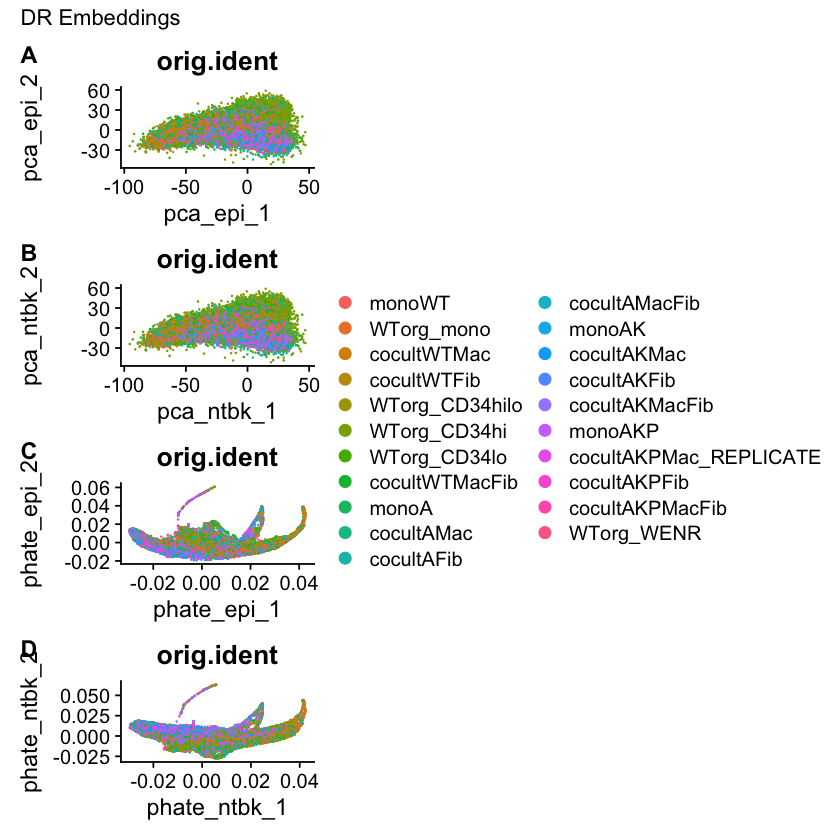

In [37]:
d_Fig2_INTepi <- RunPCA(d_Fig2_INTepi,
    assay = "integrated", reduction.name = "pca_ntbk")

phate_dr <- phateR::phate(
    d_Fig2_INTepi@reductions$pca@cell.embeddings,
    knn = 5, decay = 40, t = "auto",
    knn.dist.method = "euclidean",
    mds.solver = "sgd", mds.method = "metric", mds.dist.method = "euclidean",
    n.jobs = 1, seed = 12)
d_Fig2_INTepi[["phate_ntbk"]] <- CreateDimReducObject(embeddings = phate_dr$embedding,
    key = "PHATE_", assay = "integrated")

p1 <- DimPlot(d_Fig2_INTepi, 
    reduction = "pca_epi", group.by = "orig.ident", label = FALSE, shuffle = TRUE)
p2 <- DimPlot(d_Fig2_INTepi,
    reduction = "pca_ntbk", group.by = "orig.ident", label = FALSE, shuffle = TRUE)
p3 <- DimPlot(d_Fig2_INTepi, 
    reduction = "phate_epi", group.by = "orig.ident", label = FALSE, shuffle = TRUE)
p4 <- DimPlot(d_Fig2_INTepi,
    reduction = "phate_ntbk", group.by = "orig.ident", label = FALSE, shuffle = TRUE)
p1 + p2 + p3 + p4 + plot_layout(
    ncol = 1, nrow=4, guides = "collect") + plot_annotation(
        title = "DR Embeddings", 
        tag_levels = "A")

In [ ]:
#Load subsampled object from github:

    dsub_Fig2_INTepi.rds <- readRDS("data/dsub_Fig2_INTepi.rds")

# Gene expression plots

In [14]:
dsub_Fig2_INTepi@

$RNA
Assay data with 27434 features for 550 cells
First 10 features:
 Gm6123, Mrpl15, Gm37144, Lypla1, Gm37988, Tcea1, Rgs20, Atp6v1h,
Rb1cc1, 4732440D04Rik 

$SCT
SCTAssay data with 25846 features for 550 cells, and 21 SCTModel(s) 
First 10 features:
 Mrpl15, Gm37144, Lypla1, Gm37988, Tcea1, Rgs20, Atp6v1h, Rb1cc1,
4732440D04Rik, Pcmtd1 

$integrated
SCTAssay data with 4000 features for 550 cells, and 1 SCTModel(s) 
Top 10 variable features:
 Saa3, Gpx2, Sprr1a, Sprr2a3, Tff3, Ly6d, Agr2, Krt8, Cldn4, Spink4 

$UCellRanks
Assay data with 27434 features for 550 cells
First 10 features:
 Gm6123, Mrpl15, Gm37144, Lypla1, Gm37988, Tcea1, Rgs20, Atp6v1h,
Rb1cc1, 4732440D04Rik 


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca_epi_ to pcaepi_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_epi_ to umapepi_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from phate_epi_ to phateepi_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from phate_epi2_ to phateepi2_”


An object of class Seurat 
31434 features across 330 samples within 2 assays 
Active assay: RNA (27434 features, 0 variable features)
 1 other assay present: integrated
 7 dimensional reductions calculated: pca, umap, phate, pca_epi, umap_epi, phate_epi, phate_epi2

In [11]:
saveRDS(dsub_Fig2_INTepi, "test100.rds")

In [27]:
dsub_Fig2_INTepi[["pca"]] = NULL
dsub_Fig2_INTepi

An object of class Seurat 
31434 features across 378 samples within 2 assays 
Active assay: RNA (27434 features, 0 variable features)
 1 other assay present: integrated
 6 dimensional reductions calculated: umap, phate, pca_epi, umap_epi, phate_epi, phate_epi2